In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
THRESH_SPO2_LOW = 92
THRESH_SPO2_CRITICAL = 88
THRESH_SHOCK_INDEX_WARNING = 0.9
THRESH_SHOCK_INDEX_CRITICAL = 1.0
THRESH_MAP_LOW = 65  # Mean Arterial Pressure threshold for shock
THRESH_LACTATE_HIGH = 2.0  # mmol/L for tissue hypoperfusion
THRESH_LACTATE_CRITICAL = 4.0
THRESH_UO_LOW = 0.5  # mL/kg/hr (oliguria)

# Trend Analysis
TREND_WINDOW = 6  # Number of readings for short-term trend analysis


# AGE-SPECIFIC VITAL SIGN THRESHOLDS (Low, Normal, High)

AGE_THRESHOLDS = {
    'neonate': {
        'rr_low': 30, 'rr_normal': 40, 'rr_high': 60,
        'hr_low': 100, 'hr_normal': 140, 'hr_high': 160,
        'sbp_low': 60, 'sbp_normal': 70, 'sbp_high': 90,
        'temp_low': 36.0, 'temp_normal': 37.2, 'temp_high': 38.0
    },
    'infant': {
        'rr_low': 24, 'rr_normal': 30, 'rr_high': 40,
        'hr_low': 80, 'hr_normal': 120, 'hr_high': 140,
        'sbp_low': 70, 'sbp_normal': 85, 'sbp_high': 100,
        'temp_low': 36.0, 'temp_normal': 37.2, 'temp_high': 38.0
    },
    'child': {
        'rr_low': 16, 'rr_normal': 20, 'rr_high': 30,
        'hr_low': 70, 'hr_normal': 90, 'hr_high': 110,
        'sbp_low': 80, 'sbp_normal': 95, 'sbp_high': 110,
        'temp_low': 36.0, 'temp_normal': 37.0, 'temp_high': 38.0
    },
    'adolescent': {
        'rr_low': 12, 'rr_normal': 16, 'rr_high': 20,
        'hr_low': 60, 'hr_normal': 75, 'hr_high': 100,
        'sbp_low': 90, 'sbp_normal': 105, 'sbp_high': 120,
        'temp_low': 35.8, 'temp_normal': 36.8, 'temp_high': 37.8
    },
    'adult': {
        'rr_low': 12, 'rr_normal': 16, 'rr_high': 20,
        'hr_low': 60, 'hr_normal': 80, 'hr_high': 100,
        'sbp_low': 90, 'sbp_normal': 115, 'sbp_high': 130,
        'temp_low': 35.5, 'temp_normal': 36.8, 'temp_high': 38.0
    },
    'geriatric': {  # Added for elderly patients who may have different baselines
        'rr_low': 12, 'rr_normal': 16, 'rr_high': 24, # Often higher RR baseline
        'hr_low': 55, 'hr_normal': 70, 'hr_high': 90, # Often lower HR
        'sbp_low': 90, 'sbp_normal': 125, 'sbp_high': 140, # Often higher SBP
        'temp_low': 35.5, 'temp_normal': 36.5, 'temp_high': 37.5 # Often lower temp
    }
}


SCORE_THRESHOLDS = {
    "hypotensive_shock": {  
        "yellow": 3,   # Monitor/Review
        "orange": 6,   # Urgent
        "red": 9       # Critical
    },
}


In [3]:
def assign_age_category(df):
    """
    Assigns an age category based on the 'age' column in the DataFrame.
    Now includes more granular pediatric categories and a geriatric category.
    """
    df = df.copy()
    
    def _categorize(age):
        if age <= 0.083: return 'neonate'     # < 1 month
        elif age <= 1:   return 'infant'      # 1 month - 1 year
        elif age < 5:    return 'child'       # 1 - 5 years
        elif age < 13:   return 'adolescent'  # 5 - 12 years
        elif age < 65:   return 'adult'       # 13 - 64 years
        else:            return 'geriatric'   # 65+ years
    
    if 'age' in df.columns:
        df['age_category'] = df['age'].apply(_categorize)
    else:
        # Default to adult if age is not provided
        df['age_category'] = 'adult'
    
    return df

In [4]:
def apply_vital_range_flags(df):
    """
    Applies age-specific thresholds to flag abnormal vital signs.
    Now includes flags for all parameters needed across pipelines.
    """
    df = df.copy()
    df = assign_age_category(df)  # Inject age group

    # SpO₂ flags (Absolute threshold)
    df['flag_spo2_low'] = df['spo2'] < THRESH_SPO2_LOW
    df['flag_spo2_critical'] = df['spo2'] < THRESH_SPO2_CRITICAL

    # Temperature flags
    df['flag_temp_high'] = df.apply(lambda row: row['temperature'] >= AGE_THRESHOLDS[row['age_category']]['temp_high'], axis=1)
    df['flag_temp_low'] = df.apply(lambda row: row['temperature'] < AGE_THRESHOLDS[row['age_category']]['temp_low'], axis=1)

    # Respiratory Rate flags
    df['flag_rr_low'] = df.apply(lambda row: row['resp_rate'] < AGE_THRESHOLDS[row['age_category']]['rr_low'], axis=1)
    df['flag_rr_high'] = df.apply(lambda row: row['resp_rate'] >= AGE_THRESHOLDS[row['age_category']]['rr_high'], axis=1)

    # Heart Rate flags
    df['flag_hr_low'] = df.apply(lambda row: row['heart_rate'] < AGE_THRESHOLDS[row['age_category']]['hr_low'], axis=1)
    df['flag_hr_high'] = df.apply(lambda row: row['heart_rate'] >= AGE_THRESHOLDS[row['age_category']]['hr_high'], axis=1)

    # Calculate Shock Index (handle division by zero)
    df['shock_index'] = df['heart_rate'] / np.clip(df['sbp'], a_min=1, a_max=None)    
    # Flag based on Shock Index
    df['flag_si_warning'] = df['shock_index'] >= THRESH_SHOCK_INDEX_WARNING
    df['flag_si_critical'] = df['shock_index'] >= THRESH_SHOCK_INDEX_CRITICAL

    # Blood Pressure flags
    df['flag_sbp_low'] = df.apply(lambda row: row['sbp'] < AGE_THRESHOLDS[row['age_category']]['sbp_low'], axis=1)
    df['flag_sbp_high'] = df.apply(lambda row: row['sbp'] >= AGE_THRESHOLDS[row['age_category']]['sbp_high'], axis=1)
    df['flag_dbp_low'] = df.apply(lambda row: row['dbp'] < (AGE_THRESHOLDS[row['age_category']]['sbp_low'] * 0.6), axis=1) # Estimate DBP low
    df['flag_dbp_high'] = df.apply(lambda row: row['dbp'] >= (AGE_THRESHOLDS[row['age_category']]['sbp_high'] * 0.6), axis=1) # Estimate DBP high

    return df

In [5]:
def compute_recent_trends_delta(df):
    """
    Computes trends for each vital by differencing consecutive readings.
    Applies stricter interpretation using age-specific thresholds.
    """
    df = df.copy().sort_values("timestamp").reset_index(drop=True)

    if 'age_category' not in df.columns:
        df = assign_age_category(df)

    trends = {}
    recent = df.tail(TREND_WINDOW)
    age_group = recent['age_category'].iloc[-1]
    thresholds = AGE_THRESHOLDS[age_group]

    vital_map = {
        'resp_rate': ('rr_low', 'rr_normal', 'rr_high'),
        'heart_rate': ('hr_low', 'hr_normal', 'hr_high'),
        'sbp': ('sbp_low', 'sbp_normal', 'sbp_high'),
        'temperature': ('temp_low', 'temp_normal', 'temp_high'),
        'spo2': (None, None, None)  # handled separately
    }

    for vital in ['resp_rate', 'heart_rate', 'sbp', 'temperature', 'spo2']:
        if vital not in recent.columns or recent[vital].isnull().all():
            continue

        y = recent[vital].dropna().values
        if len(y) < 2:
            continue

        avg_delta = np.mean(np.diff(y))
        latest = y[-1]
        trends[f"{vital}_trend"] = round(avg_delta, 3)

        if vital == 'spo2':
            if latest < THRESH_SPO2_LOW:
                if avg_delta > 0:
                    flag = "Still abnormal — but improving"
                elif avg_delta < 0:
                    flag = "Abnormal and worsening"
                else:
                    flag = "Abnormal and flat"
            else:
                if avg_delta < 0:
                    flag = "Normal but deteriorating"
                else:
                    flag = "Normal and stable"

        else:
            low_key, norm_key, high_key = vital_map[vital]
            low = thresholds[low_key]
            normal = thresholds[norm_key]
            high = thresholds[high_key]

            if latest < low or latest > high:
                if (latest > high and avg_delta < 0) or (latest < low and avg_delta > 0):
                    flag = "Still abnormal — but improving"
                else:
                    flag = "Abnormal and worsening"
            else:
                if avg_delta < 0:
                    flag = "Normal but deteriorating"
                else:
                    flag = "Normal and stable"

        trends[f"{vital}_trend_flag"] = flag

    # Shock Index trend
    if all(col in recent.columns for col in ['heart_rate', 'sbp']):
        hr = recent['heart_rate'].values
        sbp = np.clip(recent['sbp'].values, a_min=1, a_max=None)
        si = hr / sbp

        if len(si) >= 2:
            avg_si_delta = np.mean(np.diff(si))
            trends['shock_index_trend'] = round(avg_si_delta, 3)

            latest_si = si[-1]
            if latest_si >= THRESH_SHOCK_INDEX_HIGH:
                flag = "Shock Index high — improving" if avg_si_delta < 0 else "Shock Index high — worsening"
            else:
                flag = "Normal but improving" if avg_si_delta < 0 else "Normal but rising"

            trends['shock_index_trend_flag'] = flag

    return trends


In [6]:
def compute_trend_columns(df, window_size=TREND_WINDOW):
    """
    FOR THE HEMORRHAGIC SHOCK PIPELINE ONLY.
    For each vital, calculates a trend value (average delta) over a recent window
    of `window_size` readings and adds it as a new column for EVERY ROW.
    This is different from compute_recent_trends_delta, which returns a summary.
    """
    df = df.sort_values('timestamp').reset_index(drop=True).copy()
    
    # Create placeholder columns for the trends we need
    trend_cols = ['heart_rate', 'sbp', 'shock_index'] # We don't need all vitals for this pipeline
    for col in trend_cols:
        df[f'{col}_trend'] = np.nan  # Will hold the numeric trend value (avg delta)
        df[f'{col}_trend_flag'] = None # Will hold 'Rising', 'Falling', 'Stable'

    # Calculate rolling trends for each row
    for i in range(window_size, len(df)):
        # Get the window of recent readings (e.g., last 6 readings)
        window_data = df.iloc[i-window_size:i]
        
        for vital in trend_cols:
            if vital not in window_data.columns:
                continue
            values = window_data[vital].dropna().values
            if len(values) >= 2:  # Need at least 2 points for a trend
                avg_delta = np.mean(np.diff(values))
                df.at[i, f'{vital}_trend'] = avg_delta
                
                # Simple trend flag - we use a simpler classification than compute_recent_trends_delta
                if avg_delta > 0.1:  # Small buffer to ignore tiny fluctuations
                    df.at[i, f'{vital}_trend_flag'] = 'Rising'
                elif avg_delta < -0.1:
                    df.at[i, f'{vital}_trend_flag'] = 'Falling'
                else:
                    df.at[i, f'{vital}_trend_flag'] = 'Stable'
                    
    return df

In [7]:
def assess_hemorrhagic_shock_risk(row):
    """
    Applies the combination logic to a single row (a single set of vitals + trends).
    Returns a dictionary of triggered flags and a severity score.
    """
    flags_triggered = {}
    score = 0

    # Rule 1: Critical Shock Index (Most concerning sign)
    if row.get('flag_si_critical', False):
        flags_triggered['SHOCK_INDEX_CRITICAL'] = True
        score += 4  # High score for this critical sign

    # Rule 2: Warning Shock Index with Tachycardia & Hypotension
    if (row.get('flag_si_warning', False) and 
        row.get('flag_hr_high', False) and 
        row.get('flag_sbp_low', False)):
        flags_triggered['HEMORRHAGE_WARNING'] = True
        score += 3

    # Rule 3: Trend Analysis without fever (The core pattern)
    hr_trend_rising = row.get('heart_rate_trend_flag') == 'Rising'
    sbp_trend_falling = row.get('sbp_trend_flag') == 'Falling'
    no_fever = not row.get('flag_temp_high', True)

    if hr_trend_rising and sbp_trend_falling:
        flags_triggered['HEMORRHAGE_TREND'] = True
        score += 2
        if no_fever:
            score += 1  # Extra point if no fever (more specific for bleeding)

    # Rule 4: Early Watch (just rising HR while BP is still normal)
    sbp_normal = not row.get('flag_sbp_low', False)
    if hr_trend_rising and sbp_normal:
        flags_triggered['EARLY_WATCH'] = True
        score += 1

    # Add context from other vitals
    if row.get('flag_spo2_low', False):
        score += 1  # Hypoxia can be a late sign
    if row.get('flag_rr_high', False):
        score += 1  # Tachypnea can indicate compensation

    # Assign a severity level based on the aggregated score
    if score >= SCORE_THRESHOLDS["hypotensive_shock"]["red"]:
        severity = "RED"
    elif score >= SCORE_THRESHOLDS["hypotensive_shock"]["orange"]:
        severity = "ORANGE"
    elif score >= SCORE_THRESHOLDS["hypotensive_shock"]["yellow"]:
        severity = "YELLOW"
    else:
        severity = "GREEN"

    flags_triggered['SHOCK_SEVERITY_SCORE'] = score
    flags_triggered['SHOCK_SEVERITY_LEVEL'] = severity

    return flags_triggered

In [8]:
def plot_shock_vitals(df):
    """Plot HR, SBP, and Shock Index trends over time."""
    fig, ax1 = plt.subplots(figsize=(10,6))

    ax1.set_title("Hemorrhagic Shock / Acute Bleeding Vitals")
    ax1.set_xlabel("Time")

    # HR and SBP on left axis
    ax1.plot(df["timestamp"], df["heart_rate"], "r-", label="Heart Rate")
    ax1.plot(df["timestamp"], df["sbp"], "b-", label="SBP")
    ax1.set_ylabel("HR (bpm) / SBP (mmHg)")
    ax1.legend(loc="upper left")

    # Shock index on right axis
    ax2 = ax1.twinx()
    ax2.plot(df["timestamp"], df["shock_index"], "g--", label="Shock Index")
    ax2.axhline(THRESH_SHOCK_INDEX_WARNING, color="orange", linestyle="--", label="SI Warning (0.9)")
    ax2.axhline(THRESH_SHOCK_INDEX_CRITICAL, color="red", linestyle="--", label=f"SI Critical ({THRESH_SHOCK_INDEX_CRITICAL})")
    ax2.set_ylabel("Shock Index")
    ax2.legend(loc="upper right")

    plt.show()


In [9]:
# Example Usage
from datetime import datetime, timedelta

timestamps = [datetime.now() - timedelta(minutes=5*i) for i in range(10)][::-1]

data = {
    "timestamp": timestamps,
    "age": [30]*10,  # Adult
    "spo2":    [97, 96, 95, 94, 94, 93, 92, 91, 90, 89],   # Gradual drop
    "temperature": [36.8]*10,  # No fever
    "resp_rate": [18, 19, 20, 21, 22, 23, 24, 25, 26, 28], # Tachypnea rising
    "heart_rate": [85, 90, 95, 105, 110, 115, 120, 130, 135, 140], # Rising HR
    "sbp":        [120, 118, 115, 110, 105, 100, 95, 90, 85, 80],  # Falling SBP
    "dbp":        [80, 78, 75, 70, 68, 65, 60, 55, 50, 45],        # Falling DBP
}

df_test = pd.DataFrame(data)

# Run Your Pipeline
df_test = apply_vital_range_flags(df_test)
df_test = compute_trend_columns(df_test, window_size=6)

# Assess shock risk row by row
df_test["shock_flags"] = df_test.apply(assess_hemorrhagic_shock_risk, axis=1)

# Show last few rows
print(df_test[["timestamp","heart_rate","sbp","shock_index","heart_rate_trend_flag","sbp_trend_flag","shock_flags"]].tail())


                   timestamp  heart_rate  sbp  shock_index  \
5 2025-11-08 16:06:10.561598         115  100     1.150000   
6 2025-11-08 16:11:10.561596         120   95     1.263158   
7 2025-11-08 16:16:10.561593         130   90     1.444444   
8 2025-11-08 16:21:10.561588         135   85     1.588235   
9 2025-11-08 16:26:10.561574         140   80     1.750000   

  heart_rate_trend_flag sbp_trend_flag  \
5                  None           None   
6                Rising        Falling   
7                Rising        Falling   
8                Rising        Falling   
9                Rising        Falling   

                                         shock_flags  
5  {'SHOCK_INDEX_CRITICAL': True, 'SHOCK_SEVERITY...  
6  {'SHOCK_INDEX_CRITICAL': True, 'HEMORRHAGE_TRE...  
7  {'SHOCK_INDEX_CRITICAL': True, 'HEMORRHAGE_TRE...  
8  {'SHOCK_INDEX_CRITICAL': True, 'HEMORRHAGE_WAR...  
9  {'SHOCK_INDEX_CRITICAL': True, 'HEMORRHAGE_WAR...  


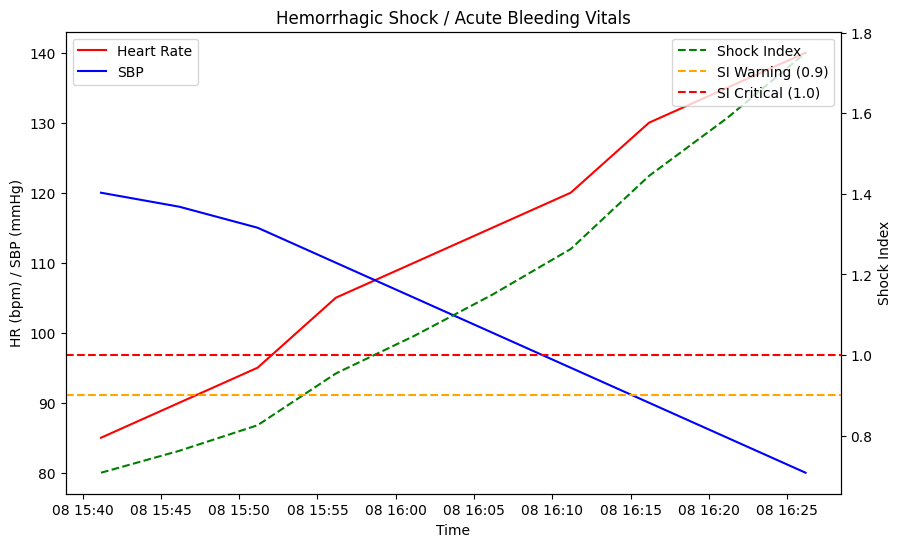

In [10]:
# Run pipeline as before
df_test = apply_vital_range_flags(df_test)
df_test = compute_trend_columns(df_test, window_size=6)
df_test["shock_flags"] = df_test.apply(assess_hemorrhagic_shock_risk, axis=1)

# Plot vitals
plot_shock_vitals(df_test)


In [11]:
def generate_shock_pipeline_output(df_final):
    """
    Processes the final DataFrame to create a clear, clinical output.
    """
    latest_row = df_final.iloc[-1]  # Get the most recent assessment
    flags = latest_row['shock_flags']
    
    output = {
        "timestamp": latest_row['timestamp'],
        "severity_score": flags.get('SHOCK_SEVERITY_SCORE', 0),
        "severity_level": flags.get('SHOCK_SEVERITY_LEVEL', 'GREEN'),
        "triggered_flags": [flag for flag in ['SHOCK_INDEX_CRITICAL', 'HEMORRHAGE_WARNING', 'HEMORRHAGE_TREND', 'EARLY_WATCH'] if flags.get(flag, False)],
        "key_metrics": {
            "Heart Rate": latest_row['heart_rate'],
            "SBP": latest_row['sbp'],
            "Shock Index": round(latest_row.get('shock_index', 0), 2),
            "HR Trend": latest_row.get('heart_rate_trend_flag', 'Unknown'),
            "SBP Trend": latest_row.get('sbp_trend_flag', 'Unknown'),
            "Temperature": latest_row['temperature'],
            "No Fever": not latest_row.get('flag_temp_high', False)
        }
    }
    
    # Add a clinical interpretation
    if output['severity_level'] == 'RED':
        output["clinical_interpretation"] = "CRITICAL: High probability of active hemorrhagic shock. Requires immediate physician assessment and intervention."
    elif output['severity_level'] == 'ORANGE':
        output["clinical_interpretation"] = "URGENT: Strong signs of hemodynamic instability consistent with bleeding. Urgent review required."
    elif output['severity_level'] == 'YELLOW':
        output["clinical_interpretation"] = "CONCERN: Early warning signs of potential blood loss. Monitor closely and review."
    else:
        output["clinical_interpretation"] = "STABLE: No significant signs of active hemorrhagic shock."
        
    return output